***In20-S4-CS3111 - Introduction to Machine Learning*** <br>
**K.S. RANASINGHE**<br>
**210518H**

#  Lab 01 - Feature Engineering



### Background
Feature engineering refers to the process of using domain knowledge to select and transform the most relevant variables from raw data when creating a predictive model using machine learning or statistical modeling. The goal of feature engineering and selection is to improve the performance of machine learning (ML) algorithms. Data preprocessing is an important step in the data mining process. It refers to the cleaning, transforming, and integrating of data in order to make it ready for analysis. The goal of data pre-processing is to improve the quality of the data. The objective of this task is to explore various data processing and feature engineering techniques to develop the best prediction machine learning model.

First, we import the required libraries




In [1]:
import pandas as pd
import numpy as np

#we are using the SimpleImputer to fill missing values because using a more complex method 
#can be too computationally intensive since we are dealing with a large dataset.
from sklearn.impute import SimpleImputer

#we are using the Ordinal Encoder to encode categorical values since some features can take
#a variety of values which would not be suitable for applying One Hot Encoding
from sklearn.preprocessing import OrdinalEncoder

#we could go with Normalization or Standardization here but we decided with Standardization 
#because it would help us in the future when we come to Feature Selection
from sklearn.preprocessing import StandardScaler

#libraries given below are used in the process of Feature Selection. we are using RFE
#algorithm for feature selection. I used SelectKBest as well but RFE performed better 
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

#we can use Principal Component Analysis on top of the selected feature set to further reduce the 
#number of features
from sklearn.decomposition import PCA

#here we are importing the packages for using the XGBoost Classifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

#finally using Shapley to intepret the developed model
import shap

### Data Loading

You have been provided with a loan default prediction data set from a finance company in the United States. The data provided contain information on previous loan applicants and whether they ‘defaulted’ or not. The aim is to identify patterns that indicate if a person is likely to default, which may be used for taking actions such as denying the loan, reducing the amount of loan, lending (to risky applicants) at a higher interest rate, etc. Features, also known as variables, include credit scores, the quantity of financing queries, address details such as zip codes and states, and collections, among other factors. Details about the features are given in the data dictionary. The data set is a matrix of around 860,000 observations and 150 variables. Note that there are missing values, outliers, and features of multiple data types.

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

print('The shape of training dataset : ' + str(train_data.shape))
print('The shape of testing dataset : ' + str(test_data.shape))

The shape of training dataset : (31599, 15)
The shape of testing dataset : (7900, 14)


### Data Preprocessing

Data preprocessing is a vital step in a machine learning algorithm. We cannot use the model to predict anything if we have a incomplete dataset. That is where preprocessing comes in. Through this step we are able to fill missing data, encode any categorical data and scale down the data values so that we can run them in the model without introducing any bais.

The dataset we are using here is also incomplete. By running the below code you can get a glimpse of the quality of the training dataset.

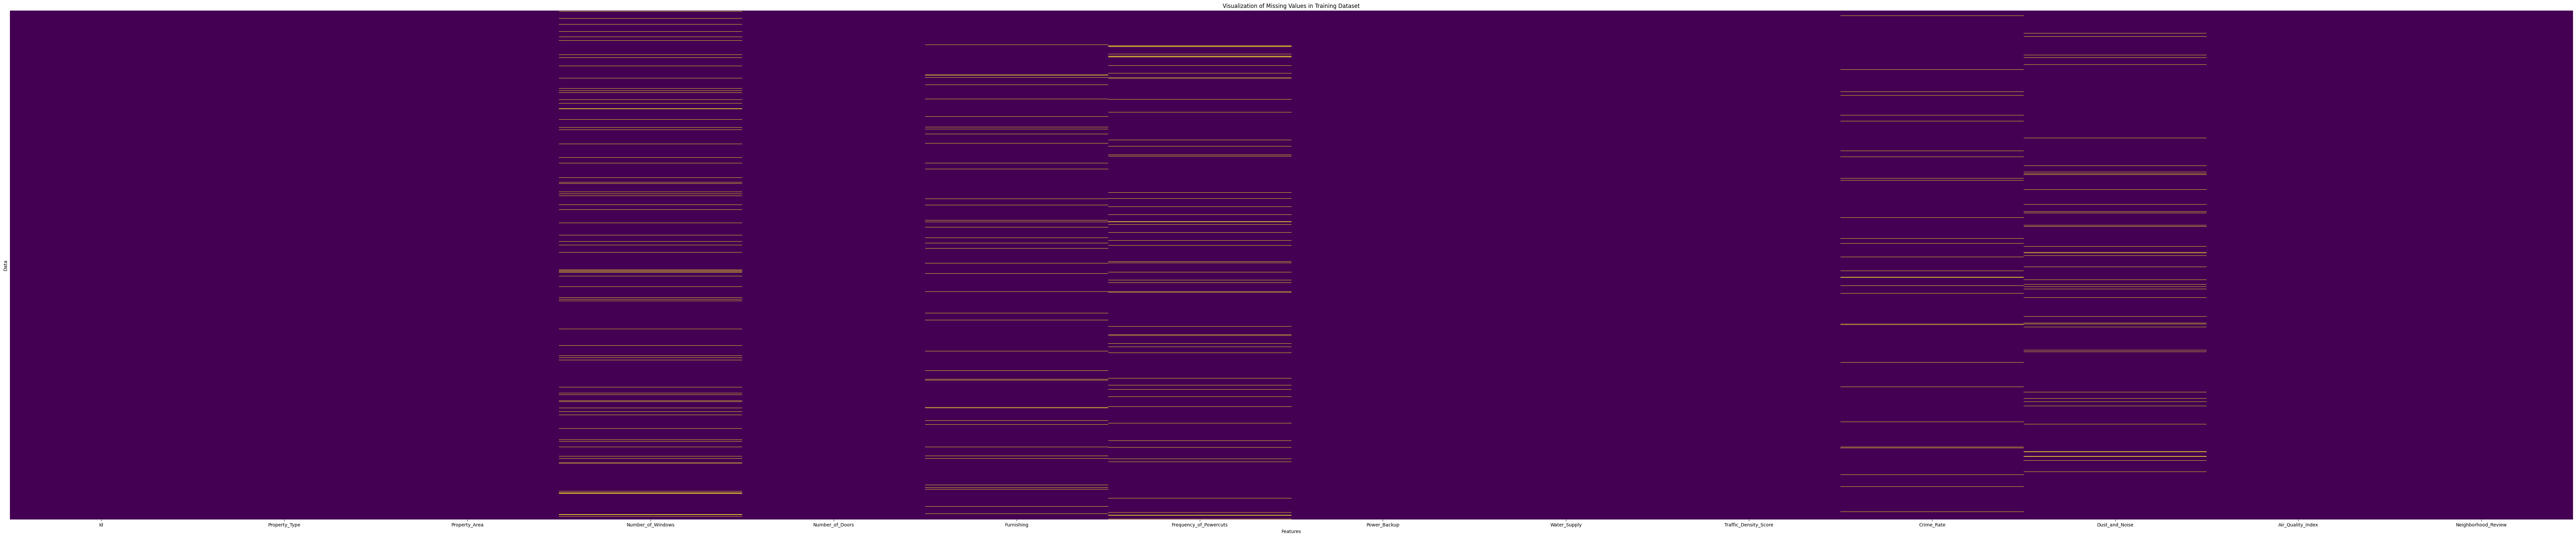

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap of missing values
plt.figure(figsize=(100,20))
sns.heatmap(test_data.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.xlabel('Features')
plt.ylabel('Data')
plt.title('Visualization of Missing Values in Training Dataset')
plt.show()


### Handling Missing Values

There are two ways that we employed in handling missing values. As you can see above from the heatmap there are features where most if not all of the data is missing. We cannot use Imputation techniques on such features as that could add a bias to the dataset since we cannot predict the performance of a feature with so little data.
<br>In our dataset we will be removing the features with more than 50% of the data missing. You could change the value for 'threshold_percentage' in the below code block and see how many features are retained.

In [4]:
# Identify columns with missing values
columns_with_missing_values = test_data.columns[test_data.isnull().any()]

# Output columns with missing values and their counts
for column in columns_with_missing_values:
    missing_count = test_data[column].isnull().sum()
    print(f"Column '{column}' has {missing_count} missing values.")


Column 'Number_of_Windows' has 321 missing values.
Column 'Furnishing' has 214 missing values.
Column 'Frequency_of_Powercuts' has 274 missing values.
Column 'Crime_Rate' has 158 missing values.
Column 'Dust_and_Noise' has 220 missing values.


In [6]:
train_data.dtypes

Id                         object
Property_Type              object
Property_Area               int64
Number_of_Windows         float64
Number_of_Doors             int64
Furnishing                 object
Frequency_of_Powercuts    float64
Power_Backup               object
Water_Supply               object
Traffic_Density_Score     float64
Crime_Rate                 object
Dust_and_Noise             object
Air_Quality_Index         float64
Neighborhood_Review       float64
Habitability_score        float64
dtype: object

In [7]:
train_data["Property_Type"].unique()

array(['Apartment', 'Bungalow', 'Single-family home', 'Duplex',
       '#R%$G&867', 'Container Home'], dtype=object)

In [8]:
train_data["Furnishing"].unique()

array(['Semi_Furnished', 'Unfurnished', 'Fully Furnished', nan],
      dtype=object)

In [9]:
train_data["Power_Backup"].unique()

array(['No', 'Yes', 'NOT MENTIONED'], dtype=object)

In [10]:
train_data["Water_Supply"].unique()

array(['Once in a day - Morning', 'Once in a day - Evening', 'All time',
       'NOT MENTIONED', 'Once in two days'], dtype=object)

In [11]:
train_data["Crime_Rate"].unique()

array(['Slightly below average', 'Well below average',
       'Well above average', nan, 'Slightly above average'], dtype=object)

In [12]:
train_data["Dust_and_Noise"].unique()

array(['Medium', nan, 'High', 'Low'], dtype=object)

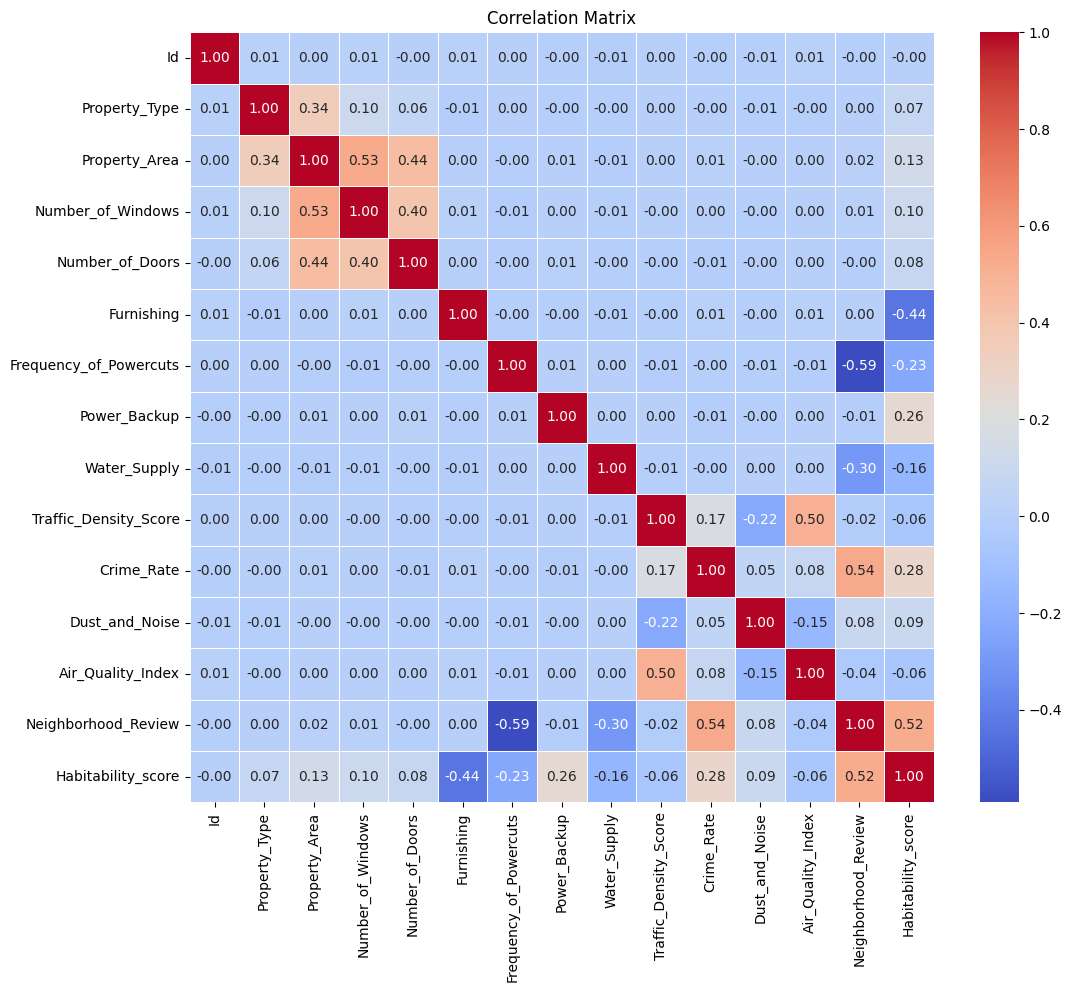

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder

# Load the dataset
train_data = pd.read_csv("train.csv")

# Encode categorical features
encoder = OrdinalEncoder()
train_data_encoded = pd.DataFrame(encoder.fit_transform(train_data), columns=train_data.columns)

# Compute the correlation matrix
corr_matrix = train_data_encoded.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [25]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder

# Load the dataset
train_data = pd.read_csv("train.csv")

# Separate numerical and categorical columns
numerical_cols = train_data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = train_data.select_dtypes(include=['object']).columns

# Initialize OrdinalEncoder for categorical variables
encoder = OrdinalEncoder()

# Encode categorical variables
train_data[categorical_cols] = encoder.fit_transform(train_data[categorical_cols])

# Initialize the KNN imputer
imputer = KNNImputer()

# Apply KNN imputation to fill missing values
imputed_train_data = pd.DataFrame(imputer.fit_transform(train_data), columns=train_data.columns)

# Check for missing values after imputation
print(imputed_train_data.isnull().sum())


Id                        0
Property_Type             0
Property_Area             0
Number_of_Windows         0
Number_of_Doors           0
Furnishing                0
Frequency_of_Powercuts    0
Power_Backup              0
Water_Supply              0
Traffic_Density_Score     0
Crime_Rate                0
Dust_and_Noise            0
Air_Quality_Index         0
Neighborhood_Review       0
Habitability_score        0
dtype: int64


In [26]:
imputed_train_data.head()

train_data = imputed_train_data

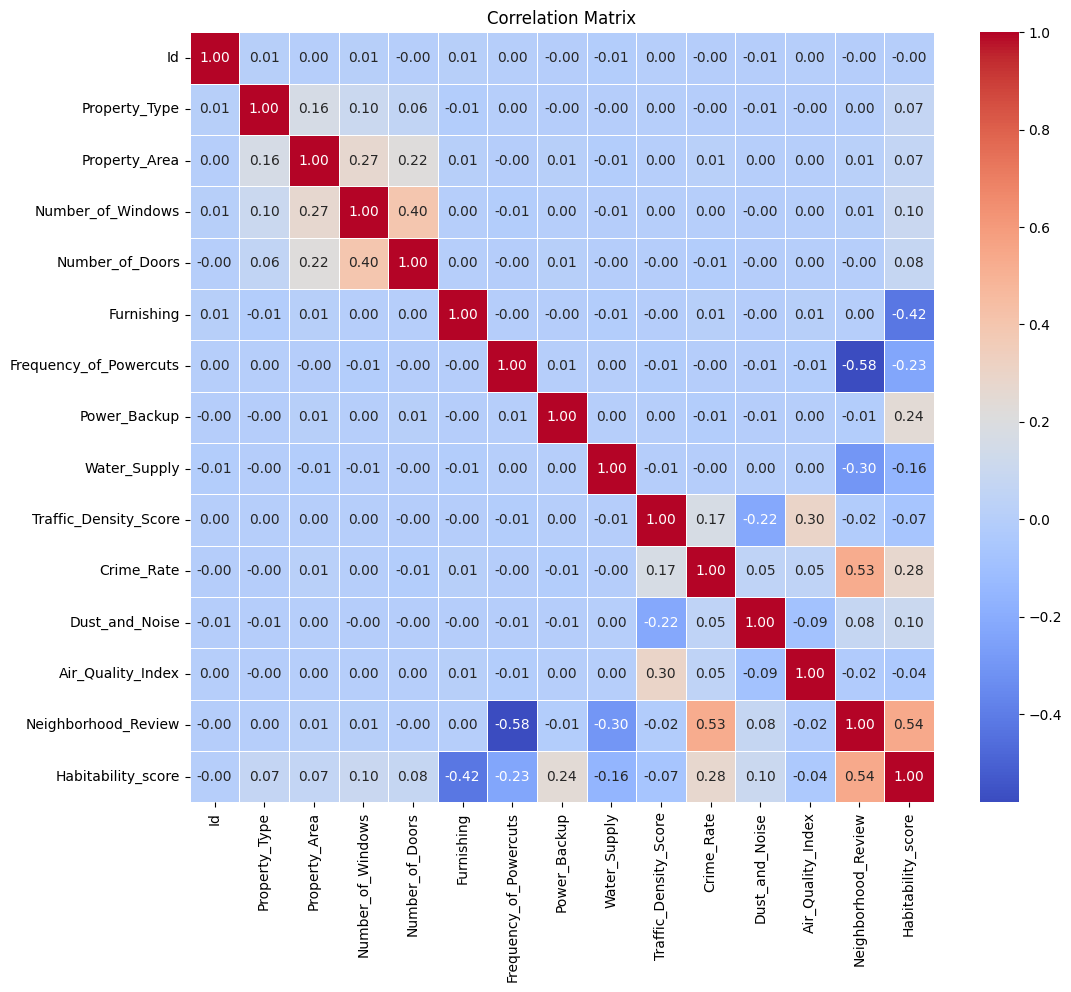

In [6]:
# Compute the correlation matrix
corr_matrix = imputed_train_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

By running the code block given below you could visualize the dataset after removing the features with large number of missing values.

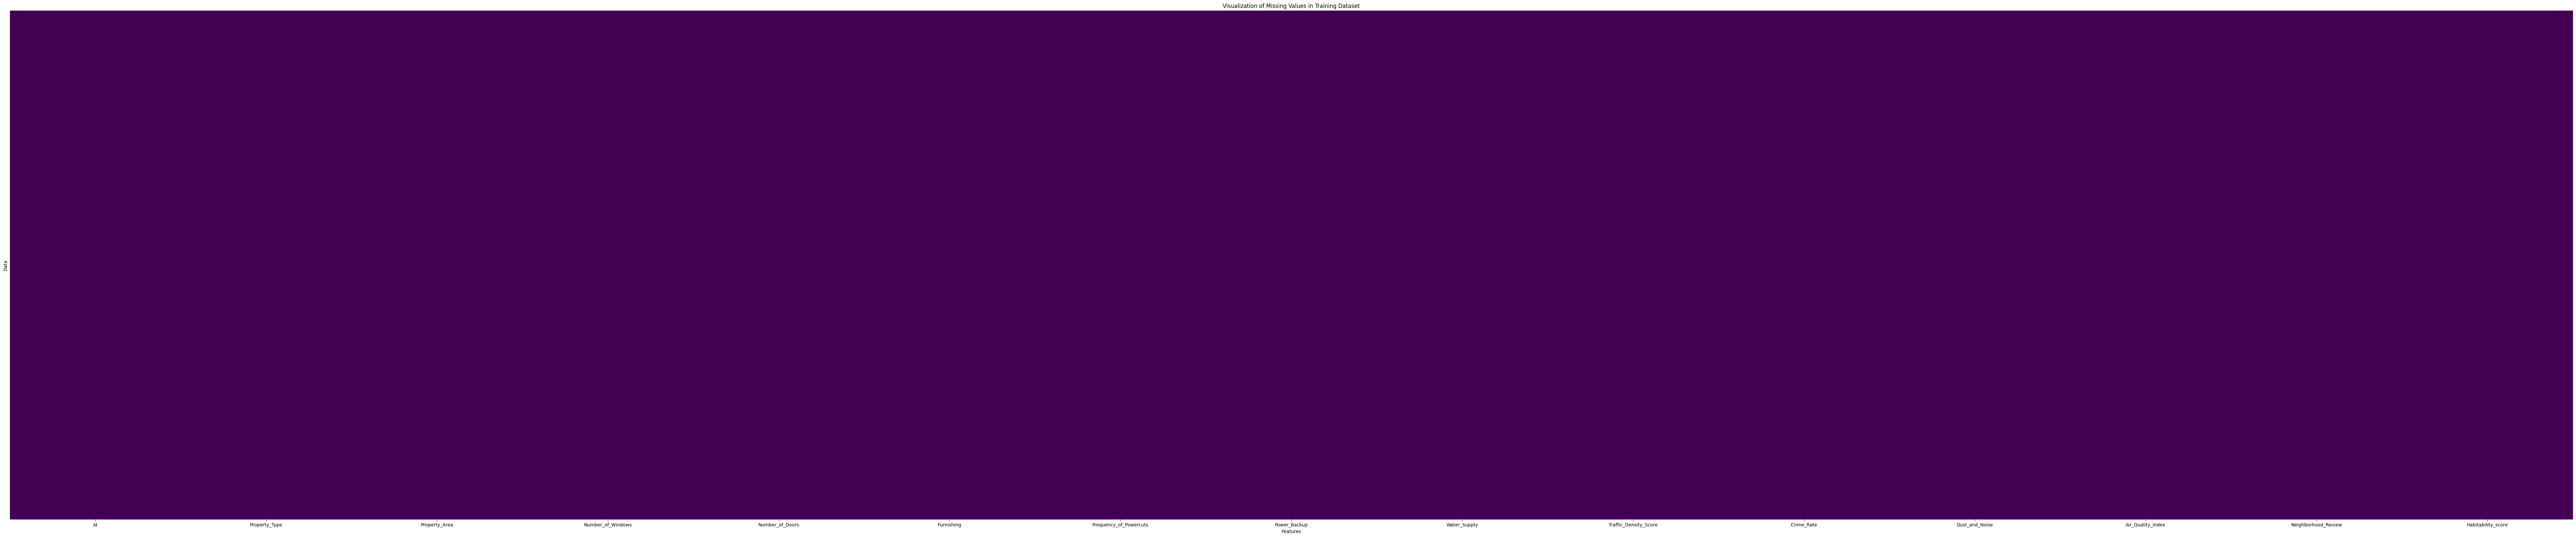

In [27]:
plt.figure(figsize=(100,20))
sns.heatmap(train_data.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.xlabel('Features')
plt.ylabel('Data')
plt.title('Visualization of Missing Values in Training Dataset')
plt.show()

Now that we have removed the features which we surely cannot use, lets complete our dataset. We are using the simple imputer to fill the missing data. But we broke down the set of features into categorical and numerical so that we could use the best imputation parameters for each. For numerical features we are using the mean and for categorical features we are using the most frequent value to fill missing data.

In [98]:
train_data['Number_of_Windows'].fillna(4, inplace=True)
train_data['Frequency_of_Powercuts'].fillna(0, inplace=True)

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




In [99]:
from sklearn.impute import SimpleImputer

# Assuming your DataFrame is named df and categorical_features contains the names of categorical columns
categorical_features = ['Furnishing', 'Crime_Rate', 'Dust_and_Noise']

# Initialize SimpleImputer with strategy='most_frequent'
imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputer on the data
imputer.fit(train_data[categorical_features])

# Transform and fill missing values
train_data[categorical_features] = imputer.transform(train_data[categorical_features])

In [37]:
train_data.head()

,Id,Property_Type,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review,Habitability_score
0,0x21e3,Apartment,106,4.0,1,Semi_Furnished,0.0,No,Once in a day - Morning,5.89,Slightly below average,Medium,90.0,3.86,71.98
1,0x68d4,Apartment,733,2.0,2,Unfurnished,1.0,No,Once in a day - Evening,4.37,Well below average,Medium,96.0,3.55,71.20
2,0x7d81,Apartment,737,4.0,2,Fully Furnished,0.0,No,Once in a day - Morning,7.45,Slightly below average,Medium,121.0,3.81,71.39
3,0x7a57,Apartment,900,3.0,2,Unfurnished,2.0,Yes,Once in a day - Morning,6.16,Well above average,Medium,100.0,1.34,31.46
4,0x9409,Bungalow,2238,14.0,6,Fully Furnished,0.0,No,All time,5.46,Well below average,Medium,116.0,4.77,93.70


### Feature Encoding

The dataset that have been provided to us contains a lot of features with categorical values. We cannot enter values like that to a machine learning model. Hence we have to convert these values into numerical. By running the code given below you can see how features contain categorical values.

We will be using the Ordinal Encoding technique for our dataset because after closely analyzing the dataset it was found that there are features which could take many categorical values. If we employ a technique like One Hot Encoding here the number of columns would increase drastically with it the computational complexity.

In [80]:
categorical_features = ['Property_Type', 'Furnishing', 'Power_Backup', 'Water_Supply', 'Crime_Rate', 'Dust_and_Noise'] 

# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Fit and transform the categorical features
train_data[categorical_features] = ordinal_encoder.fit_transform(train_data[categorical_features])

In [89]:
from sklearn.preprocessing import LabelEncoder

categorical_features = ['Property_Type', 'Furnishing', 'Power_Backup', 'Water_Supply', 'Crime_Rate', 'Dust_and_Noise'] 

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply Label Encoding to each categorical feature
for feature in categorical_features:
    train_data[feature] = label_encoder.fit_transform(train_data[feature])


In [104]:
import category_encoders as ce
categorical_features = ['Property_Type', 'Furnishing', 'Power_Backup', 'Water_Supply', 'Crime_Rate', 'Dust_and_Noise'] 
# Initialize TargetEncoder
target_encoder = ce.TargetEncoder(cols=categorical_features)

# Fit and transform the categorical features
train_data_encoded = target_encoder.fit_transform(train_data[categorical_features], train_data['Habitability_score'])

# Concatenate the encoded categorical features with the rest of the dataset
train_data_encoded = pd.concat([train_data.drop(columns=categorical_features), train_data_encoded], axis=1)
train_data_encoded.head()
train_data = train_data_encoded

In [105]:
train_data.head()

,Property_Area,Number_of_Windows,Number_of_Doors,Frequency_of_Powercuts,Traffic_Density_Score,Air_Quality_Index,Neighborhood_Review,Habitability_score,Property_Type,Furnishing,Power_Backup,Water_Supply,Crime_Rate,Dust_and_Noise
0,106,4.0,1,0.0,5.89,90.0,3.86,71.98,71.662255,75.367228,71.379682,73.206276,73.539878,73.788846
1,733,2.0,2,1.0,4.37,96.0,3.55,71.20,71.662255,63.763597,71.379682,70.115944,77.776349,73.788846
2,737,4.0,2,0.0,7.45,121.0,3.81,71.39,71.662255,81.046488,71.379682,73.206276,73.539878,73.788846
3,900,3.0,2,2.0,6.16,100.0,1.34,31.46,71.662255,63.763597,80.304431,73.206276,54.816195,73.788846
4,2238,14.0,6,0.0,5.46,116.0,4.77,93.70,77.060870,81.046488,71.379682,75.745654,77.776349,73.788846


In [9]:
train_data = train_data.drop(columns=['Id'])

In [10]:
train_data.head()

,Property_Type,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review,Habitability_score
0,1.0,106.0,2.2,1.0,1.0,0.0,1.0,3.0,5.89,1.0,2.0,90.0,3.86,71.98
1,1.0,733.0,2.0,2.0,2.0,1.0,1.0,2.0,4.37,3.0,2.0,96.0,3.55,71.20
2,1.0,737.0,4.0,2.0,0.0,0.0,1.0,3.0,7.45,1.0,2.0,121.0,3.81,71.39
3,1.0,900.0,3.0,2.0,2.0,2.0,2.0,3.0,6.16,2.0,2.0,100.0,1.34,31.46
4,2.0,2238.0,14.0,6.0,0.0,0.0,1.0,0.0,5.46,3.0,2.0,116.0,4.77,93.70


Another thing that is noticable after doing all this is that there exists features with zero variance across the dataset. That means all the rows for the feature contains the same value. These features are redundant as they cannot help us in predicting anything and adds a computational complexity as we still have to process them every time for no reason. So lets remove these features from the dataset.

### Feature Scaling

We will be using Standardization for scaling the dataset. There is no particular reason for choosing this over Normalization except that the data would be more spread out in Standardization compared to the other.


In [18]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data)

# Convert the scaled NumPy array back to a DataFrame
train_data = pd.DataFrame(train_scaled, columns=train_data.columns)
train_data.head()

,Property_Type,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review,Habitability_score
0,-1.066714,-0.659552,0.026786,-1.131916,-0.098778,-0.628474,-0.450107,1.160109,-0.382854,-0.820639,0.373482,-0.505529,0.158931,-0.103023
1,-1.066714,-0.338123,-0.731641,-0.283241,1.386836,0.709834,-0.450107,0.455169,-1.629394,0.908407,0.373482,-0.408865,-0.229401,-0.158161
2,-1.066714,-0.336072,0.026786,-0.283241,-1.584392,-0.628474,-0.450107,1.160109,0.896489,-0.820639,0.373482,-0.006099,0.096297,-0.144730
3,-1.066714,-0.252511,-0.352428,-0.283241,1.386836,2.048141,1.756707,1.160109,-0.161430,0.043884,0.373482,-0.344423,-2.997826,-2.967333
4,-0.487574,0.433410,3.818920,3.111459,-1.584392,-0.628474,-0.450107,-0.954711,-0.735494,0.908407,0.373482,-0.086652,1.298870,1.432337


Another reason behind choosing Standardization is we could apply Dimensionality Reduction techniques like Principal Component Analysis and reduce the number of features in the dataset which inturn would reduce the computational complexity. We will get to more on this later. Change the value for 'n_components' to see how many features are retained.

In [107]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor  # You can use any estimator

# Assuming train_data contains your preprocessed dataset with features and target variable
# Splitting the data into features (X) and target variable (y)
X = train_data.drop(columns=['Habitability_score'])  # Replace 'target_column' with the name of your target variable
y = train_data['Habitability_score']

# Initialize the model (you can choose any estimator)
estimator = RandomForestRegressor()

# Initialize RFE
selector = RFE(estimator, n_features_to_select=13, verbose=2)

# Fit RFE to the training data
selector.fit(X, y)

# Get selected features
selected_features = X.columns[selector.support_]

# Filter the dataset to keep only selected features
X_selected = X[selected_features]


In [113]:
from sklearn.decomposition import PCA

# Initialize PCA with the desired number of components
pca = PCA(n_components=13)  # Choose the number of components you want to keep

# Fit PCA to the selected features
X_pca = pca.fit_transform(X_selected)

# Convert the transformed data into a DataFrame
X_pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(pca.n_components_)])

# Now X_pca_df contains the selected features after applying PCA


In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Assuming train_data contains your preprocessed dataset with features and target variable
# Splitting the data into features (X) and target variable (y)
X = train_data.drop(columns=['Habitability_score'])  # Replace 'target_column' with the name of your target variable
y = train_data['Habitability_score']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing the XGBRegressor model
xgb_regressor = XGBRegressor()

# Fitting the model to the training data
xgb_regressor.fit(X_train, y_train)

# Making predictions on the test data
y_pred = xgb_regressor.predict(X_test)

# Evaluating the model using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 38.6290751491686


In [29]:
from sklearn.ensemble import RandomForestRegressor

# Assuming train_data contains your preprocessed dataset with features and target variable
# Splitting the data into features (X) and target variable (y)
X = train_data.drop(columns=['Habitability_score'])  # Replace 'target_column' with the name of your target variable
y = train_data['Habitability_score']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing the RandomForestRegressor model
rf_regressor = RandomForestRegressor()

# Fitting the model to the training data
rf_regressor.fit(X_train, y_train)

# Making predictions on the test data
y_pred = rf_regressor.predict(X_test)

# Evaluating the model using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (Random Forest):", mse)


Mean Squared Error (Random Forest): 34.93202371472627


### Test Data


In [21]:
test_data['Number_of_Windows'].fillna(4, inplace=True)
test_data['Frequency_of_Powercuts'].fillna(0, inplace=True)

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




In [22]:
# Assuming your DataFrame is named df and categorical_features contains the names of categorical columns
categorical_features = ['Furnishing', 'Crime_Rate', 'Dust_and_Noise']

# Initialize SimpleImputer with strategy='most_frequent'
imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputer on the data
imputer.fit(test_data[categorical_features])

# Transform and fill missing values
test_data[categorical_features] = imputer.transform(test_data[categorical_features])

In [23]:
test_data.head()

,Id,Property_Type,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review
0,0x6808,Single-family home,1521,5.0,1,Unfurnished,0.0,No,All time,7.61,Well below average,Medium,156.0,4.71
1,0x6a98,Single-family home,2233,2.0,1,Semi_Furnished,0.0,No,Once in a day - Morning,5.28,Well below average,Medium,82.0,4.50
2,0xacc0,Apartment,986,1.0,1,Unfurnished,0.0,No,All time,7.72,Well below average,Medium,91.0,4.79
3,0x8225,Single-family home,1625,2.0,1,Semi_Furnished,0.0,No,Once in a day - Evening,6.19,Well below average,Medium,159.0,4.09
4,0xaee8,Single-family home,1166,2.0,2,Fully Furnished,0.0,No,Once in a day - Evening,5.84,Slightly below average,Medium,82.0,3.56


In [24]:
categorical_features = ['Property_Type', 'Furnishing', 'Power_Backup', 'Water_Supply', 'Crime_Rate', 'Dust_and_Noise'] 

# Initialize OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Fit and transform the categorical features
test_data[categorical_features] = ordinal_encoder.fit_transform(test_data[categorical_features])

In [25]:
test_data = test_data.drop(columns=['Id'])

In [26]:
scaler = StandardScaler()
test_scaled = scaler.fit_transform(test_data)

# Convert the scaled NumPy array back to a DataFrame
test_data = pd.DataFrame(test_scaled, columns=test_data.columns)
test_data.head()

,Property_Type,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review
0,1.241631,0.067567,0.412900,-1.114170,1.387547,-0.628334,-0.470289,-0.947740,1.034999,0.895315,0.374083,0.546230,1.217346
1,1.241631,0.430162,-0.731228,-1.114170,-0.091155,-0.628334,-0.470289,1.172264,-0.873605,0.895315,0.374083,-0.616914,0.951822
2,-1.065799,-0.204888,-1.112605,-1.114170,1.387547,-0.628334,-0.470289,-0.947740,1.125105,0.895315,0.374083,-0.475451,1.318498
3,1.241631,0.120531,-0.731228,-1.114170,-0.091155,-0.628334,-0.470289,0.465596,-0.128185,0.895315,0.374083,0.593385,0.433417
4,1.241631,-0.113221,-0.731228,-0.271314,-1.569858,-0.628334,-0.470289,0.465596,-0.414885,-0.824979,0.374083,-0.616914,-0.236715


In [27]:
# Making predictions on the test data
y_pred = xgb_regressor.predict(test_data)

test_data = pd.read_csv("test.csv")

df_predictions = pd.DataFrame({'Id': test_data['Id'], 'Habitability_score': y_pred})

# Write the DataFrame to a new CSV file
df_predictions.to_csv("predictions.csv", index=False)

### Dimensionality Reduction

Using Dimensionality Reduction we could further reduce the number of features in our dataset while preserving as much information as possible. In here we will be using Principal Component Analysis as our technique. The number of features to extract is set to 4. 

In [13]:
pca = PCA(n_components=4)  # No. of features after applying PCA

X_train = train_scaled_df[selected_features]
X_train_pca = pca.fit_transform(X_train)
X_train_pca_df = pd.DataFrame(X_train_pca)
print("Train data shape:", X_train_pca_df.shape)

Train data shape: (517788, 4)


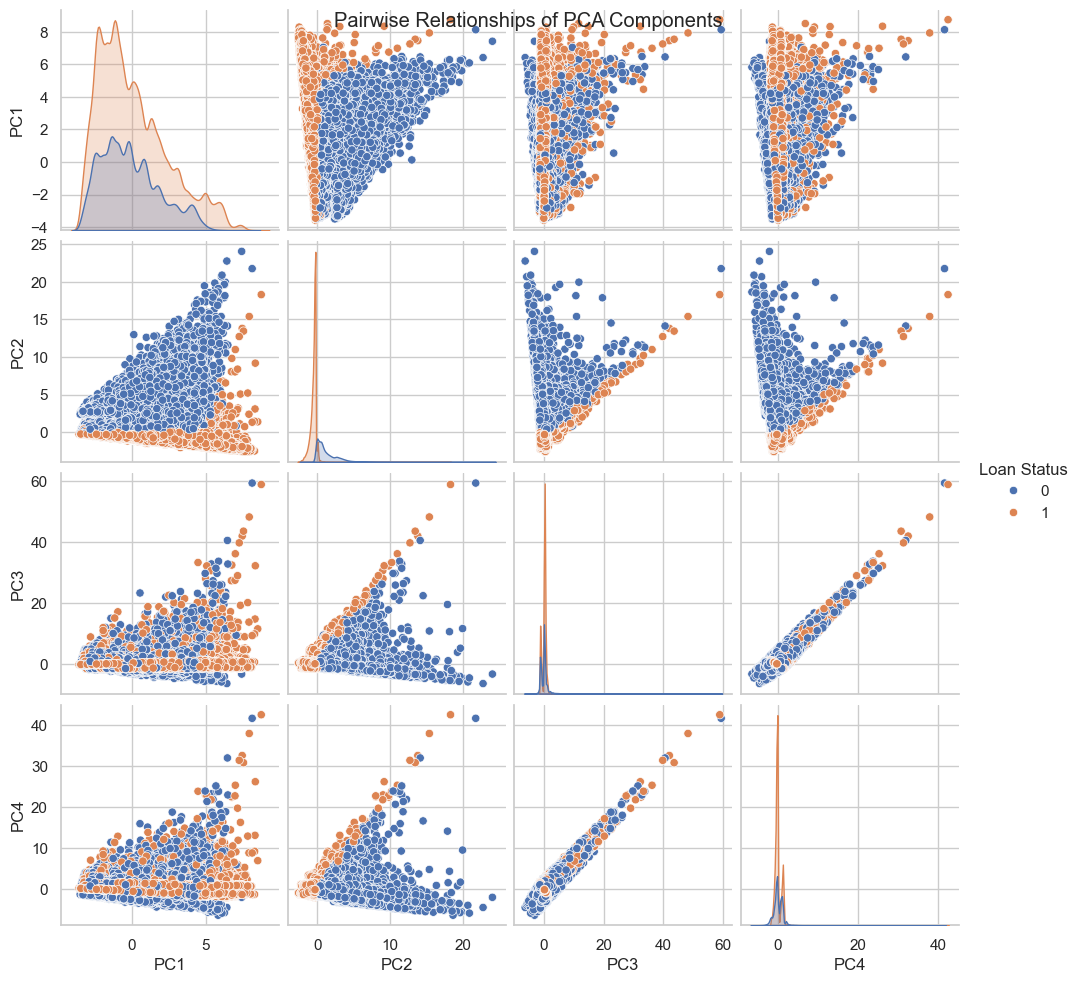

In [31]:
import seaborn as sns

# Create a DataFrame with the principal components
pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i}' for i in range(1, 5)])

# Add the target variable for coloring
pca_df['Loan Status'] = y_train

# Create a pairplot
sns.pairplot(pca_df, hue='Loan Status', diag_kind='kde')
plt.suptitle('Pairwise Relationships of PCA Components')
plt.show()



### Pre-processing Valid and Test Datasets

Now the feature engineering is complete. What is left is to do is to validate the model using a Classifier. But before that we need to repeat what we have done above for the validation and testing datasets.

In [14]:
# Filling Missing Values
threshold_percentage = 50
missing_val_count_by_column = valid_data.isnull().sum()
percentage_missing = (missing_val_count_by_column / len(valid_data)) * 100
columns_to_drop = percentage_missing[percentage_missing > threshold_percentage].index
valid_filtered = valid_data.drop(columns=columns_to_drop)

numeric_columns = valid_filtered.select_dtypes(include='number').columns
categorical_columns = valid_filtered.select_dtypes(exclude='number').columns
numeric_columns_with_missing_values = [col for col in numeric_columns if valid_filtered[col].isnull().any()]
categorical_columns_with_missing_values = [col for col in categorical_columns if valid_filtered[col].isnull().any()]
numeric_imputer = SimpleImputer(strategy='mean') 
categorical_imputer = SimpleImputer(strategy='most_frequent')
valid_imputed_numeric = valid_filtered.copy()
valid_imputed_numeric[numeric_columns_with_missing_values] = numeric_imputer.fit_transform(valid_filtered[numeric_columns_with_missing_values])
valid_imputed_categorical = valid_imputed_numeric.copy()
valid_imputed_categorical[categorical_columns_with_missing_values] = categorical_imputer.fit_transform(valid_imputed_numeric[categorical_columns_with_missing_values])

missing_val_count_by_column = test_data.isnull().sum()
percentage_missing = (missing_val_count_by_column / len(test_data)) * 100
columns_to_drop = percentage_missing[percentage_missing > threshold_percentage].index
test_filtered = test_data.drop(columns=columns_to_drop)

numeric_columns = test_filtered.select_dtypes(include='number').columns
categorical_columns = test_filtered.select_dtypes(exclude='number').columns
numeric_columns_with_missing_values = [col for col in numeric_columns if test_filtered[col].isnull().any()]
categorical_columns_with_missing_values = [col for col in categorical_columns if test_filtered[col].isnull().any()]
test_imputed_numeric = test_filtered.copy()
test_imputed_numeric[numeric_columns_with_missing_values] = numeric_imputer.fit_transform(test_filtered[numeric_columns_with_missing_values])
test_imputed_categorical = test_imputed_numeric.copy()
test_imputed_categorical[categorical_columns_with_missing_values] = categorical_imputer.fit_transform(test_imputed_numeric[categorical_columns_with_missing_values])

# Feature Encoding
s = (valid_imputed_categorical.dtypes == 'object')
object_cols = list(s[s].index)
ordinal_encoder = OrdinalEncoder()
valid_encoded = valid_imputed_categorical.copy()
valid_encoded[object_cols] = ordinal_encoder.fit_transform(valid_imputed_categorical[object_cols])
columns_to_drop = valid_encoded.columns[valid_encoded.nunique() == 1]
valid_encoded.drop(columns=columns_to_drop, inplace=True)

s = (test_imputed_categorical.dtypes == 'object')
object_cols = list(s[s].index)
test_encoded = test_imputed_categorical.copy()
test_encoded[object_cols] = ordinal_encoder.fit_transform(test_imputed_categorical[object_cols])
columns_to_drop = test_encoded.columns[test_encoded.nunique() == 1]
test_encoded.drop(columns=columns_to_drop, inplace=True)

# Feature Scaling
scaler = StandardScaler()
valid_scaled = scaler.fit_transform(valid_encoded)
valid_scaled_df = pd.DataFrame(valid_scaled, columns=valid_encoded.columns)

test_scaled = scaler.fit_transform(test_encoded)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_encoded.columns)

# Feature Selection
X_valid = valid_scaled_df[selected_features]
y_valid = valid_data['loan_status']

X_test = test_scaled_df[selected_features]

# Dimensionality Reduction
pca = PCA(n_components=4)
X_valid_pca = pca.fit_transform(X_valid)
X_valid_pca_df = pd.DataFrame(X_valid_pca)
print("Valid data shape:", X_valid_pca_df.shape)

pca = PCA(n_components=4)
X_test_pca = pca.fit_transform(X_test)
X_test_pca_df = pd.DataFrame(X_test_pca)
print("Test data shape:", X_test_pca_df.shape)

Valid data shape: (172596, 4)
Test data shape: (172596, 4)


### XGBoost Classifier

We will create a classifier and then tune the hyperparameters using the validation dataset based on the performance of the model

Disclaimer : The code given below will iterate through different sets of hyperparameters given below and decide the best performing set of hyperparameters. But this process will take a long time to complete. By running the code given afterwards you can get the accuracy of the best set of hyperparameters directly instead.

In [ ]:
# Define the hyperparameters to tune
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)

# Fit GridSearchCV to find the best hyperparameters
grid_search.fit(X_train_pca_df, y_train)
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the model with the best hyperparameters on the validation set
best_clf = grid_search.best_estimator_
accuracy = best_clf.score(X_valid_pca_df, y_valid)
print("Validation Accuracy:", accuracy)

In [16]:
# Define the hyperparameters to tune
param_grid = {
    'max_depth': [7],
    'learning_rate': [0.01],
    'n_estimators': [300],
    'gamma': [0.1],
    'subsample': [0.8],
    'colsample_bytree': [1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)

# Fit GridSearchCV to find the best hyperparameters
grid_search.fit(X_train_pca, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the model with the best hyperparameters on the validation set
best_clf = grid_search.best_estimator_
accuracy = best_clf.score(X_valid_pca, y_valid)
print("Validation Accuracy:", accuracy)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.8; total time=   2.5s
Best Hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Validation Accuracy: 0.9949013882129366


In [17]:
best_clf.fit(X_train_pca, y_train)
y_valid_pred = best_clf.predict(X_valid_pca)

accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.99


### Predicting Target Label

We will use the model 'best_clf' and the test dataset 'X_test_pca_df' to predict 'loan_status' for the testing dataset. And write the results into 210518H.csv in the required format.

In [ ]:
# Make predictions on the test dataset
predicted_labels = best_clf.predict(X_test_pca_df)

# Create a DataFrame with predicted labels and features
predicted_df = pd.DataFrame(predicted_labels, columns=['loan_status'])
predicted_df = pd.concat([predicted_df, X_test_pca_df.reset_index(drop=True)], axis=1)

# Write the DataFrame to a CSV file
predicted_df.to_csv('210518H.csv', index=False)

By running the below code block you could get an idea of the distribution of target variable across both train dataset and predicted test dataset.

In [18]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("210518H.csv")

y_train = train_data['loan_status']
y_test = test_data['loan_status']

y_pred_series = pd.Series(y_test)

# Count the occurrences of each class label in the predicted dataset
predicted_label_counts = y_pred_series.value_counts()
predicted_label_percentages = predicted_label_counts / len(y_pred_series) * 100

y_train_series = pd.Series(y_train)

# Count the occurrences of each class label in the training dataset
training_label_counts = y_train_series.value_counts()
training_label_percentages = training_label_counts / len(y_train_series) * 100

print("Predicted Label Percentages:")
print(predicted_label_percentages)
print("\nTraining Label Percentages:")
print(training_label_percentages)

Predicted Label Percentages:
loan_status
1    69.60648
0    30.39352
Name: count, dtype: float64

Training Label Percentages:
loan_status
1    69.680062
0    30.319938
Name: count, dtype: float64


### SHAP analysis for explainable AI

100%|===================| 172590/172596 [46:32<00:00]        

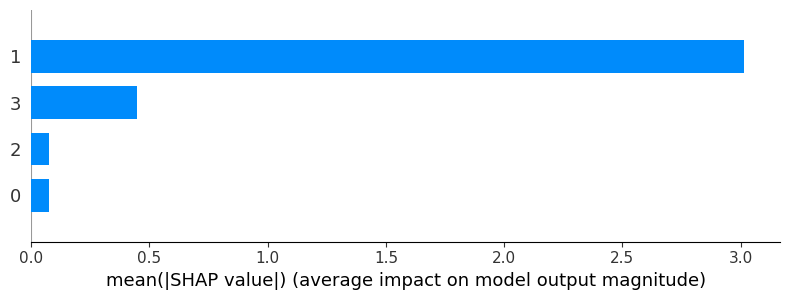

In [19]:
# Initialize an explainer object
explainer = shap.Explainer(best_clf, X_train_pca_df)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_pca_df)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_test_pca_df, plot_type="bar")

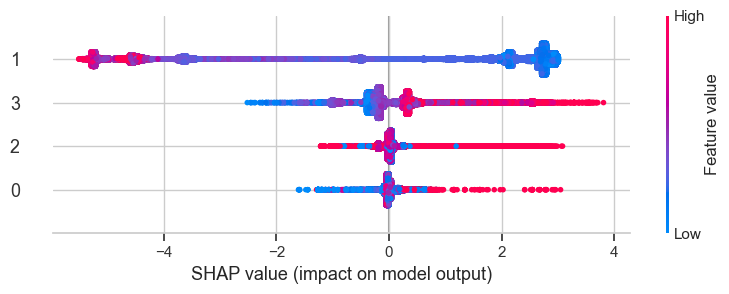

In [32]:
shap.summary_plot(shap_values, X_test_pca_df)

In [33]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test_pca_df.iloc[0])

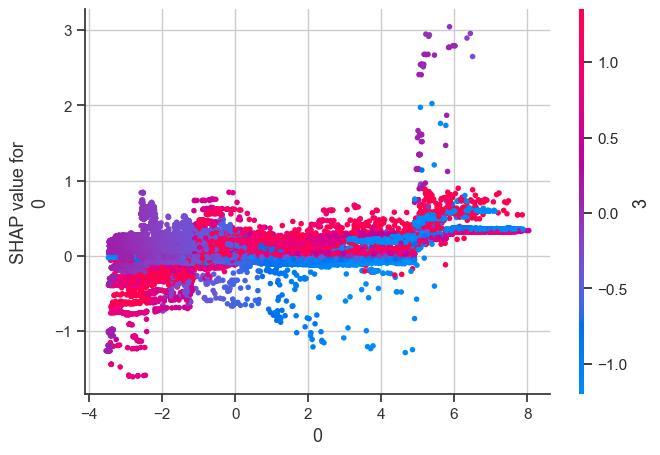

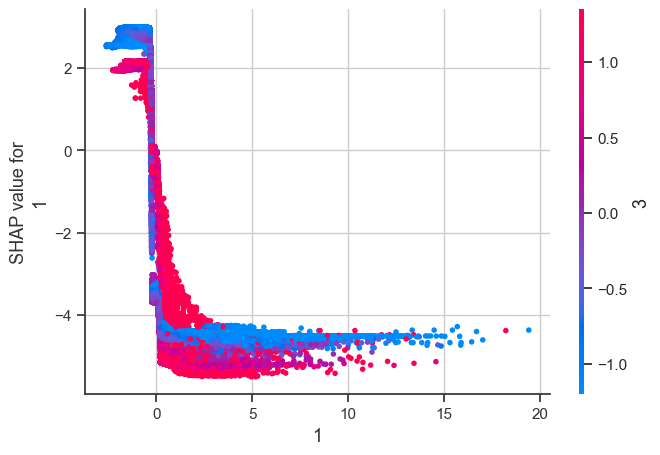

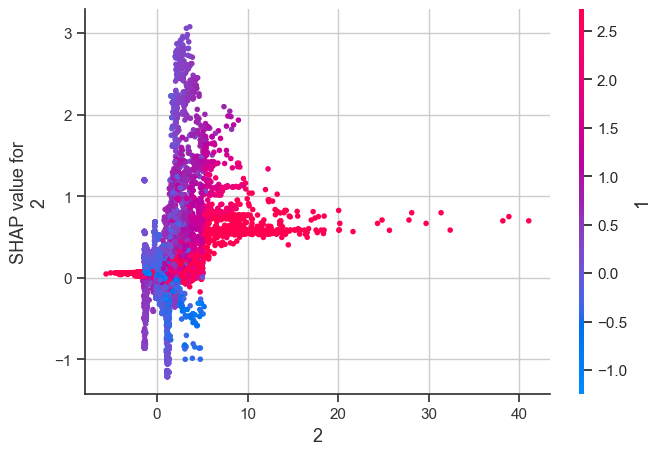

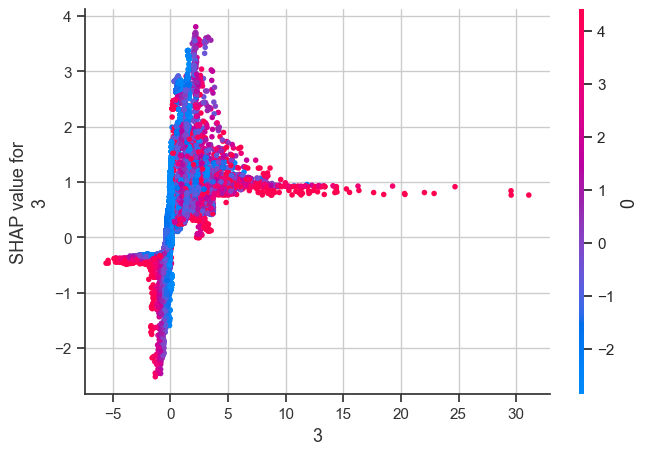

In [41]:
shap.dependence_plot(0, shap_values, X_test_pca_df)
shap.dependence_plot(1, shap_values, X_test_pca_df)
shap.dependence_plot(2, shap_values, X_test_pca_df)
shap.dependence_plot(3, shap_values, X_test_pca_df)